In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal
from sympy import symbols, Matrix, exp, integrate, eye
from sympy.utilities.lambdify import lambdify

In [2]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, u_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)
        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layerout = nn.Linear(self.hidden_dim, u_dim, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=2)
        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 
        z_out = self.layerout(h) 
        return z_out

In [3]:
N = 2000 # number of samples
T = 100  # number of time steps
n = 8 # system dimension
m = 4 # control dimension

tf = 1.0 # time horizon
# dt = tf/T # time step

n_sigma = 1 # noise level

In [4]:
T_mat = torch.zeros((m, m))
torch.diagonal(T_mat).fill_(2)
torch.diagonal(T_mat, offset=1).fill_(-1)
torch.diagonal(T_mat, offset=-1).fill_(-1)
A = torch.cat((torch.cat((torch.zeros((m, m)), torch.eye(m)), dim=1), torch.cat((-T_mat, -torch.eye(m)), dim=1)), dim=0)
B = torch.cat((torch.zeros((m, m)), torch.eye(m)), dim=0)

In [5]:
def generate_onetime_phit(A, B, t, dt, n, N):
    """
    t is the scalar time, dt is the time step, output shape is (N, n, n), this function is used to generate the phi_t at time t
    """
    # phi_t = torch.zeros((N, n, n))
    idx = (t // dt + 1).int()
    # print(idx)
    integral_recorder = torch.zeros((idx, n, n))
    for i in range(idx):
        integral_recorder[i] = torch.matrix_exp((t - i * dt) * A) @ B @ B.T @ torch.matrix_exp((t - i * dt) * A.T) * dt
    phi_one_time_t = torch.sum(integral_recorder, dim=0)
    phi_one_time_t = phi_one_time_t.repeat(N, 1, 1)
    return phi_one_time_t
    


In [6]:
x_0 = MultivariateNormal(torch.zeros(n), torch.eye(n)).sample((N,))
y = torch.zeros((N,n))
y[:int(N/2)] = MultivariateNormal(torch.tensor([3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0]), torch.eye(n)).sample((int(N/2),))
y[int(N/2):] = MultivariateNormal(torch.tensor([-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0]), torch.eye(n)).sample((N//2,))

In [7]:
X_f = torch.zeros((T, N, n))
W_f = torch.zeros((T, N, m))


X_f[0] = x_0

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)
dt = t_N[1,0,0] - t_N[0,0,0]

In [8]:
def generate_phit(t, n, dt):
    """
    t shape is (T, N, 1), output shape is (T, N, n, n)
    """
    T, N, _ = t.shape
    phi_t = torch.zeros((T, N, n, n))
    for i in range(T):
        phi_t[i] = generate_onetime_phit(A, B, t[i,0,0], dt, n, N)
    return phi_t

In [9]:
def generate_expAt(A, t):
    """
    A shape is (n,n), t shape is (T,N,1), output shape is (T,N,n,n)
    """
    T, N, _ = t.shape
    A_rep = A.repeat(T,N,1,1)
    A_t = A_rep * t.unsqueeze(-1)
    A_t_exp = torch.matrix_exp(A_t)

    return A_t_exp

In [10]:
expAt = generate_expAt(A, t_N)
exp1tAtrans = generate_expAt(A.T, 1-t_N)
expA = generate_expAt(A, torch.ones_like(t_N))
exp1tA = generate_expAt(A, 1-t_N)
phi_t = generate_phit(t_N, n, dt)
phi_1 = generate_phit(torch.ones_like(t_N), n, dt)
phi_1_t = generate_phit(1-t_N, n, dt)

mat_for_x = expAt - torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans), torch.linalg.inv(phi_1)), expA)

mat_for_y = torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans), torch.linalg.pinv(phi_1))

phi_t_exp1tAtrans = torch.einsum('tnij,tnjk->tnik', phi_t, exp1tAtrans)
Sigma_t = phi_t - torch.einsum('tnij,tnjk->tnik', torch.einsum('tnij,tnjk->tnik', phi_t_exp1tAtrans, torch.linalg.pinv(phi_1)), phi_t_exp1tAtrans.transpose(-1,-2))

Z_f = torch.zeros((T, N, n))
for i in range(T):
    try:
        Z_f[i,:,:] = MultivariateNormal(torch.zeros(n), Sigma_t[i,0,:,:]).sample((N,))
    except:
        print(i)

0
99


In [11]:
X_f = torch.einsum('tnij,tnj->tni', mat_for_x, x_0.unsqueeze(0).repeat(T,1,1)) + torch.einsum('tnij,tnj->tni', mat_for_y, y.unsqueeze(0).repeat(T,1,1)) + n_sigma * Z_f

In [12]:
u_f = torch.einsum('tnij,tnj->tni',torch.einsum('tnij,tnjk->tnik', torch.einsum('ij,tnjk->tnik', B.T, exp1tAtrans), torch.linalg.pinv(phi_1_t)), y[None,:,:] - torch.einsum('tnij, tnj->tni', exp1tA, X_f))

In [13]:
print(X_f[-1,:,:].mean(dim = 0))
print(X_f[-1,:,:].std(dim = 0))

tensor([ 0.0183, -0.0184,  0.0016,  0.0013,  0.0230,  0.0048,  0.0171,  0.0279])
tensor([3.1621, 3.1534, 3.1509, 3.1615, 3.1537, 3.1830, 3.1637, 3.1762])


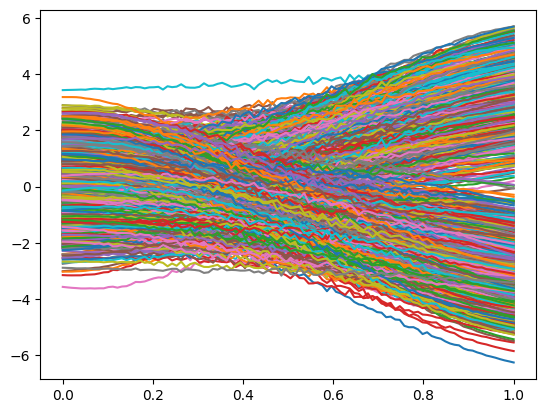

In [14]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,0])

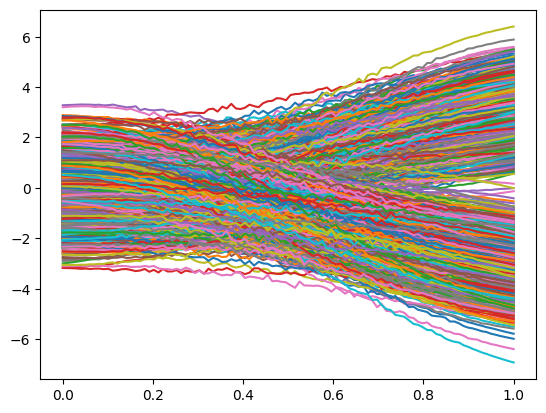

In [15]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,1])

In [16]:
### learning u = k(x,t)###

ITERS = 20000
BATCH_SIZE = 32
LR = 1e-3

k = score_nn(n, m, 16)
# init_weights(f)
k.train()
optimizer_k = torch.optim.Adam(k.parameters(), lr=LR)
scheduler_k = torch.optim.lr_scheduler.StepLR(optimizer_k, step_size=2000, gamma=0.99)

for i in range(ITERS):
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_f[:,idx,:]
    t_train = t_N[:,idx,:]  
    u_train = u_f[:,idx,:]
    k_value = k.forward(X_train,t_train) 
    loss = nn.MSELoss()(k_value,u_train)
    
    optimizer_k.zero_grad()
    loss.backward()
    optimizer_k.step()
    scheduler_k.step()
    
    if  (i+1)==ITERS or (i+1)%100==0:
        k_value = k.forward(X_f,t_N)
        loss = ((k_value-u_f)*(k_value-u_f)).mean()
        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 100/20000, loss = 55.327171325684
Iteration: 200/20000, loss = 47.074611663818
Iteration: 300/20000, loss = 44.185100555420
Iteration: 400/20000, loss = 41.245620727539
Iteration: 500/20000, loss = 39.101249694824
Iteration: 600/20000, loss = 37.332214355469
Iteration: 700/20000, loss = 36.204528808594
Iteration: 800/20000, loss = 35.561985015869
Iteration: 900/20000, loss = 35.149715423584
Iteration: 1000/20000, loss = 34.898876190186
Iteration: 1100/20000, loss = 34.730010986328
Iteration: 1200/20000, loss = 34.771518707275
Iteration: 1300/20000, loss = 34.653915405273
Iteration: 1400/20000, loss = 34.507511138916
Iteration: 1500/20000, loss = 34.467948913574
Iteration: 1600/20000, loss = 34.459350585938
Iteration: 1700/20000, loss = 34.446823120117
Iteration: 1800/20000, loss = 34.355041503906
Iteration: 1900/20000, loss = 34.358875274658
Iteration: 2000/20000, loss = 34.336490631104
Iteration: 2100/20000, loss = 34.343074798584
Iteration: 2200/20000, loss = 34.2457656860

In [17]:
N = 2000
T = 1000

t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T

W_b = torch.zeros((T, N, m))
for i in range(T):
    W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
W_b = torch.cat((torch.zeros((T,N,m)), W_b), dim=2)

X_b = torch.zeros(T,N,n)
X_b[0] = torch.randn(N,n)
#X_b[0] = X[0].clone()
for i in range(0,T-1):
    u_pred = k.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
    
    X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u_pred.T).T * dt + n_sigma * W_b[i]

In [18]:
### Learning y = f(x,t) ###

# ITERS = 20000
# BATCH_SIZE = 32
# LR = 1.5e-3

# f = score_nn(n,16)
# # init_weights(f)
# f.train()
# optimizer_f = torch.optim.Adam(f.parameters(), lr=LR)
# scheduler_f = torch.optim.lr_scheduler.StepLR(optimizer_f, step_size=1000, gamma=0.99)

# for i in range(ITERS):
#     idx = torch.randperm(N)[:BATCH_SIZE]
#     X_train = X_f[:,idx,:]
#     t_train = t_N[:,idx,:]  
#     Y_train = y[idx,:]
#     f_value = f.forward(X_train,t_train) 
#     loss = ((f_value-Y_train)*(f_value-Y_train)).mean()
    
#     optimizer_f.zero_grad()
#     loss.backward()
#     optimizer_f.step()
#     scheduler_f.step()
    
#     if  (i+1)==ITERS or (i+1)%100==0:
#         f_value = f.forward(X_f,t_N)
#         loss = ((f_value-y)*(f_value-y)).mean()
        
#         print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

In [19]:
# N = 2000
# T = 1000

# t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
# dt = tf/T

# W_b = torch.zeros((T, N, m))
# for i in range(T):
#     W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
# W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

# X_b = torch.zeros(T,N,n)
# X_b[0] = torch.randn(N,n)
# #X_b[0] = X[0].clone()
# for i in range(0,T-1):
#     y_pred = f.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
#     # print(torch.inverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])))
#     u = (torch.tensor([[1 - t[i,0,0],1]]) @ torch.pinverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])) @ (y_pred - (torch.tensor([[1, 1-t[i,0,0]],[0, 1]]) @ X_b[i].T).T).T).T
#     # print(y_pred)
#     X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u.T).T * dt + n_sigma * W_b[i]

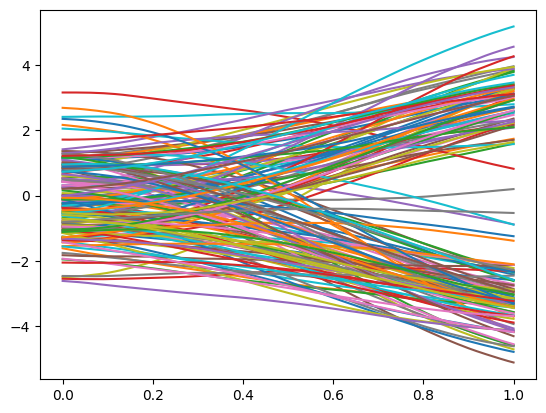

In [20]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,0].detach().numpy())

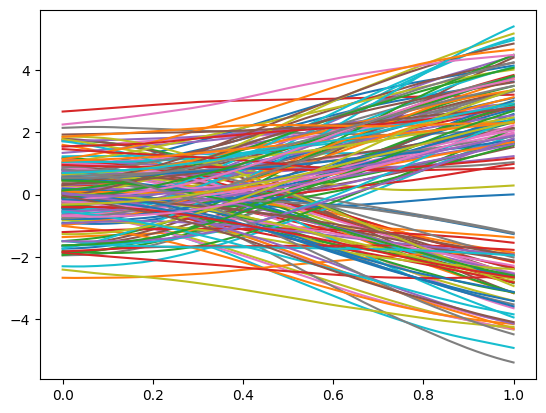

In [21]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,1].detach().numpy())

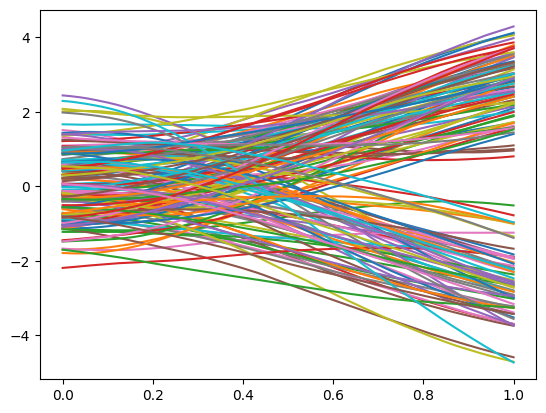

In [22]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,2].detach().numpy())

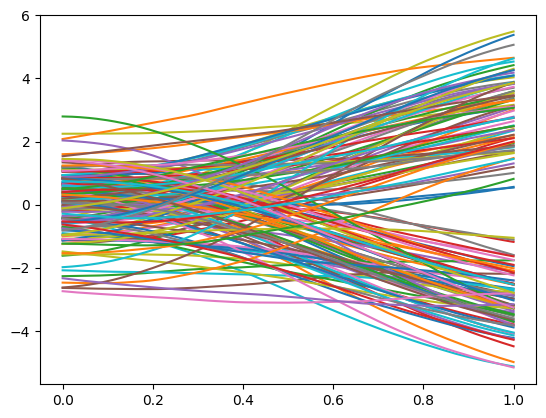

In [23]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:,i,0],X_b[:,i,3].detach().numpy())

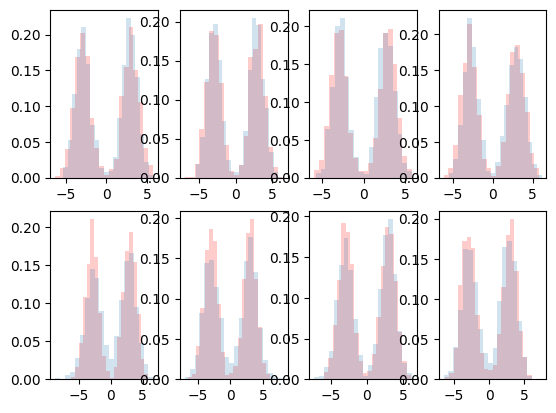

In [29]:
plt.figure()
plt.subplot(2,4,1)
plt.hist(y.numpy()[:,0],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,0],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,2)
plt.hist(y.numpy()[:,1],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,1],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,3)
plt.hist(y.numpy()[:,2],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,2],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,4)
plt.hist(y.numpy()[:,3],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,3],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,5)
plt.hist(y.numpy()[:,4],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,4],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,6)
plt.hist(y.numpy()[:,5],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,5],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,7)
plt.hist(y.numpy()[:,6],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,6],alpha=0.2, density=True, bins=20)
plt.subplot(2,4,8)
plt.hist(y.numpy()[:,7],alpha=0.2, color='r',density=True, bins=20)
plt.hist(X_b.detach().numpy()[-1,:,7],alpha=0.2, density=True, bins=20)
plt.show()


In [25]:
print(X_b[-1,:,:].detach().mean(dim = 0))
print(X_b[-1,:,:].detach().std(dim = 0))

tensor([0.0969, 0.0508, 0.0465, 0.1095, 0.0963, 0.1232, 0.0600, 0.1002])
tensor([3.0345, 3.0591, 2.9361, 3.0133, 3.0929, 3.2396, 3.2140, 3.0307])
